
# Min Graph Coloring Problem



## Background

Given a graph $G = (V,E)$, find the minimal number of colors k required to properly color it.
A coloring is legal if:

- each vetrex ${v_i}$ is assigned with a color $k_i \in \{0, 1, ..., k-1\}$
- adajecnt vertex have different colors: for each $v_i, v_j$ such that $(v_i, v_j) \in E$, $k_i \neq k_j$.
A graph which is k-colorable but not (k−1)-colorable is said to have chromatic number k. The maximum bound on the chromatic number is $D_G + 1$, where $D_G$ is the maximum vertex degree. The graph coloring problem is known to be in the NP-hard complexity class.

## Solving the problem with classiq



### Necessary Packages

In this demo, besides the `classiq` package, we'll use the following packages:


In [1]:
%%capture
! pip install 'networkx[default]'
! pip install pyomo
! pip install matplotlib

### Define the optimization problem


We encode the graph coloring with a matrix of variables `X` with dimensions $k \times |V|$ using one-hot encoding, such that a $X_{ki} = 1$ means that vertex i is colored by color k.

We require that each vertex is colored by exactly one color and that 2 adjacent vertices have different colors.

In [2]:
import networkx as nx
import numpy as np
import pyomo.environ as pyo


def define_min_graph_coloring_model(graph, max_num_colors):
    model = pyo.ConcreteModel()

    nodes = list(graph.nodes())
    colors = range(0, max_num_colors)

    model.x = pyo.Var(colors, nodes, domain=pyo.Binary)
    x_variables = np.array(list(model.x.values()))

    adjacency_matrix = nx.convert_matrix.to_numpy_array(graph, nonedge=0)
    adjacency_matrix_block_diagonal = np.kron(np.eye(degree_max), adjacency_matrix)

    model.conflicting_color_constraint = pyo.Constraint(
        expr=x_variables @ adjacency_matrix_block_diagonal @ x_variables == 0
    )

    @model.Constraint(nodes)
    def each_vertex_is_colored(model, node):
        return sum(model.x[color, node] for color in colors) == 1

    def is_color_used(color):
        is_color_not_used = np.prod([(1 - model.x[color, node]) for node in nodes])
        return 1 - is_color_not_used

    # minimize the number of colors in use
    model.value = pyo.Objective(
        expr=sum(is_color_used(color) for color in colors), sense=pyo.minimize
    )

    return model

### Initialize the model with example graph

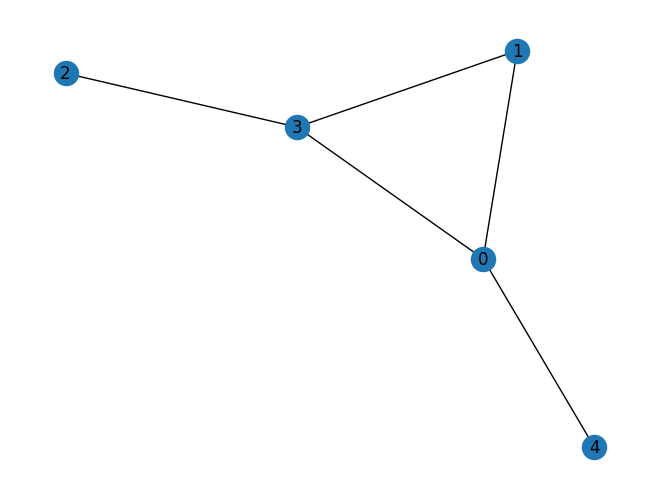

In [3]:
graph = nx.erdos_renyi_graph(5, 0.3, seed=79)
nx.draw_kamada_kawai(graph, with_labels=True)

degree_sequence = sorted((d for n, d in graph.degree()), reverse=True)
degree_max = max(degree_sequence)
max_num_colors = degree_max

coloring_model = define_min_graph_coloring_model(graph, max_num_colors)

### show the resulting pyomo model

In [4]:
coloring_model.pprint()

4 Set Declarations
    each_vertex_is_colored_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {0, 1, 2, 3, 4}
    x_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : x_index_0*x_index_1 :   15 : {(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)}
    x_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {0, 1, 2}
    x_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {0, 1, 2, 3, 4}

1 Var Declarations
    x : Size=15, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : 

### Initialize classiq QAOA solver

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [5]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=6, penalty_energy=10.0)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [6]:
optimizer_config = OptimizerConfig(alpha_cvar=0.3)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [7]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=coloring_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [8]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="aer_simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [9]:
with open("min_graph_coloring.qmod", "w") as f:
    f.write(qmod)

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [10]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/d106b87f-f005-45ac-ad62-7edf1f3fd748?version=0.34.0.dev0%2B124706fb0e


We now solve the problem using the generated circuit by using the `execute` method:

In [11]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

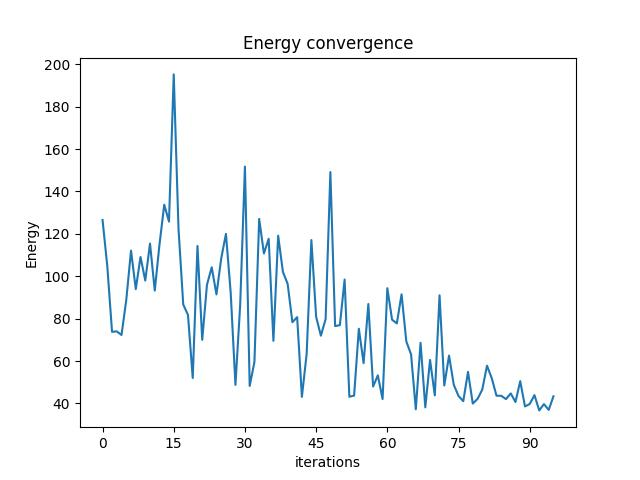

In [12]:
from classiq.execution import VQESolverResult

vqe_result = res[1].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [13]:
import pandas as pd

optimization_result = pd.DataFrame.from_records(res[0].value)
optimization_result.sort_values(by="cost", ascending=False).head(5)

,probability,cost,solution,count
3,0.003,9203.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",3
926,0.001,8013.0,"[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
67,0.002,8013.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]",2
924,0.001,5933.0,"[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
921,0.001,5933.0,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]",1


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

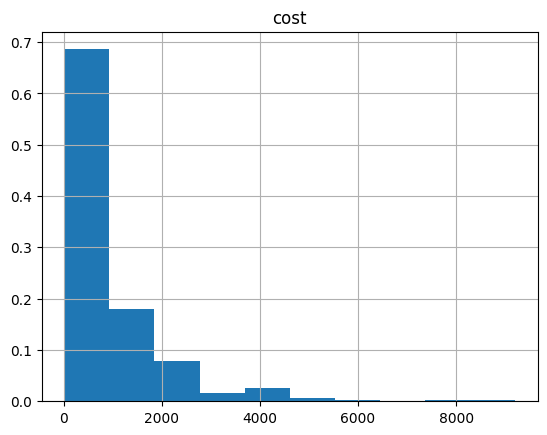

In [14]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Let us plot the best solution:

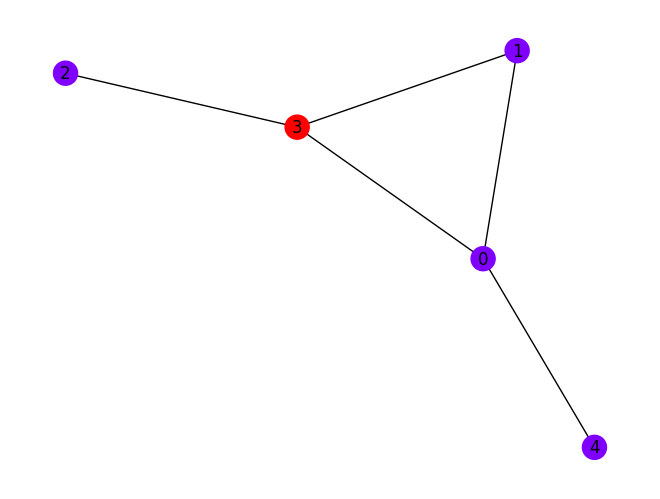

In [15]:
import matplotlib.pyplot as plt

best_solution = optimization_result.solution[optimization_result.cost.idxmin()]

one_hot_solution = np.array(best_solution).reshape([max_num_colors, len(graph.nodes)])
integer_solution = np.argmax(one_hot_solution, axis=0)
nx.draw_kamada_kawai(
    graph, with_labels=True, node_color=integer_solution, cmap=plt.cm.rainbow
)

## Classical optimizer results

Lastly, we can compare to the classical solution of the problem:

In [16]:
from pyomo.common.errors import ApplicationError
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
result = None
try:
    result = solver.solve(coloring_model)
except ApplicationError:
    print("Solver might have not exited normally. Try again")

coloring_model.display()

ERROR: Solver (asl) returned non-zero return code (-11)
ERROR: Solver log: Couenne 0.5.8 -- an Open-Source solver for Mixed Integer
    Nonlinear Optimization Mailing list: couenne@list.coin-or.org
    Instructions: http://www.coin-or.org/Couenne couenne:
Solver might have not exited normally. Try again
Model unknown

  Variables:
    x : Size=15, Index=x_index
        Key    : Lower : Value : Upper : Fixed : Stale : Domain
        (0, 0) :     0 :  None :     1 : False :  True : Binary
        (0, 1) :     0 :  None :     1 : False :  True : Binary
        (0, 2) :     0 :  None :     1 : False :  True : Binary
        (0, 3) :     0 :  None :     1 : False :  True : Binary
        (0, 4) :     0 :  None :     1 : False :  True : Binary
        (1, 0) :     0 :  None :     1 : False :  True : Binary
        (1, 1) :     0 :  None :     1 : False :  True : Binary
        (1, 2) :     0 :  None :     1 : False :  True : Binary
        (1, 3) :     0 :  None :     1 : False :  True : Bin

In [17]:
if result:
    classical_solution = [
        pyo.value(coloring_model.x[i, j])
        for i in range(max_num_colors)
        for j in range(len(graph.nodes))
    ]
    one_hot_solution = np.array(classical_solution).reshape(
        [max_num_colors, len(graph.nodes)]
    )
    integer_solution = np.argmax(one_hot_solution, axis=0)
    nx.draw_kamada_kawai(
        graph, with_labels=True, node_color=integer_solution, cmap=plt.cm.rainbow
    )